In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from neural_flow import Flow, train
from neural_flow.bijectors import RollingSplineCoupling, ShiftBounds
from neural_flow.utils import FeedForwardNetwork
from flax import linen as nn
import optax
import numpy as np

In [2]:
X, C = make_moons(10_000, noise=0.1, random_state=1)

C = C.reshape(-1, 1)
X_train, X_test, C_train, C_test = train_test_split(X, C, random_state=1)

flow = Flow(
    ShiftBounds(),
    RollingSplineCoupling(make_network=lambda n: FeedForwardNetwork(n, 2, 128)),
)

params, best_epoch, train_losses, test_losses = train(
    flow, X_train, C_train, X_test, C_test, optimizer=optax.nadamw(learning_rate=1e-3)
)
test_losses[best_epoch]

Output()

0.3491895794868469

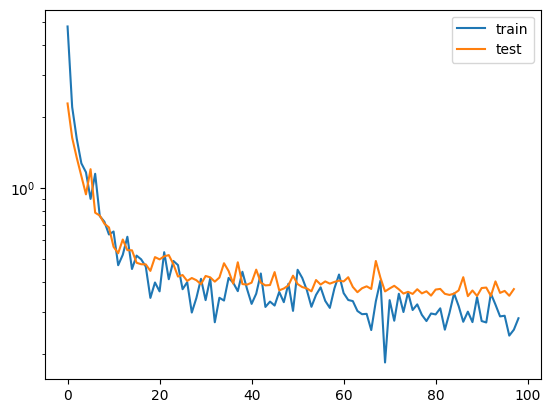

In [3]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.semilogy()
plt.legend();

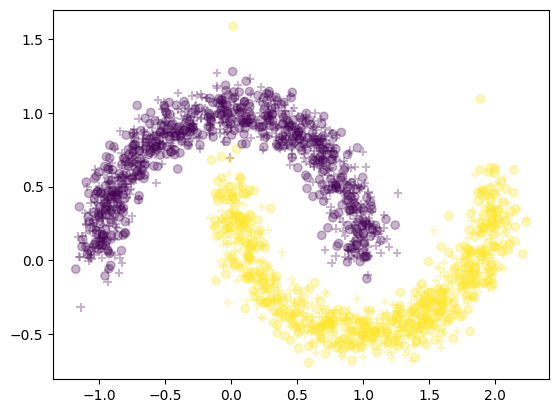

In [4]:
Cm = C_test[:1000]
Xm = flow.sample(params, Cm)
plt.scatter(*Xm.T, c=Cm, marker="o", alpha=0.3)
plt.scatter(*X_test[:1000].T, c=C_test[:1000], marker="+", alpha=0.3);